# Chapter 13: Convolutional Neural Networks

## Exercise 8.

Classifying large images using Inception v3. The code here is taken mostly from the author's solution since this exercise is mainly just learning how to use the API.

In [0]:
!pip install tensorflow-gpu

### a. Download some images of various animals. Load them in Python, for example using `matplotlib.image.mpimg.imread()` function or the `scipy.misc.imread()` function. Resize and/or crop them to 299$\times$299 pixels, and ensure that they have 3 channels (RGB). Ensure the images' values range from -1.0 to 1.0 to be compatible with Inception v3.

In [1]:
!ls img

ml_armadillo.jpg  ml_hippo.jpg	ml_owl.jpg	   ml_raccoon.jpg
ml_dog.jpg	  ml_lion.jpg	ml_polar_bear.jpg  ml_tiger.jpg


In [0]:
# Defining a function to transform the image for Inception v3.

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.transform import resize

height = 299
width = 299

def load_and_transform_img(filepath):
  img = mpimg.imread(filepath)
  h, w, _ = img.shape
  if w < h:
    dy = h - w
    img = img[dy//2:h-dy//2,:,:]
  else:
    dx = w - h
    img = img[:,dx//2:w-dx//2,:]
  img = resize(img, (height, width, 3))
  img = 2 * img - 1
  return img

### b. Download the latest pretrained Inception v3 model.

The model is available [on Github](https://github.com/tensorflow/models/tree/master/research/slim).

In [0]:
# Downloading the pre-trained model.

import sys
import os
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = \
    os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
  percent = count * block_size * 100 // total_size
  sys.stdout.write('\rDownload: {}%'.format(percent))
  sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
  if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
    return
  os.makedirs(path, exist_ok=True)
  tgz_path = os.path.join(path, "inception_v3.tgz")
  urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
  inception_tgz = tarfile.open(tgz_path)
  inception_tgz.extractall(path=path)
  inception_tgz.close()
  os.remove(tgz_path)

In [17]:
fetch_pretrained_inception_v3()

Download: 100%

In [0]:
# Downloading the image class names

GITHUB_URL = 'https://raw.githubusercontent.com/ageron/handson-ml/'
IMAGENET_LABELS_PATH = 'master/datasets/inception/imagenet_class_names.txt'
IMAGE_LABELS_URL = os.path.join(GITHUB_URL, IMAGENET_LABELS_PATH)


def load_imagenet_labels(url=IMAGE_LABELS_URL, path=INCEPTION_PATH):
  labels_path = os.path.join(path, 'imagenet_class_names.txt')
  urllib.request.urlretrieve(url, labels_path, reporthook=download_progress)

In [29]:
load_imagenet_labels()

Download: 103%

In [0]:
# Defining a function to extract the class names from the file on Github.

import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
  path = os.path.join('datasets', 'inception', 'imagenet_class_names.txt')
  with open(path, encoding='utf-8') as f:
    content = f.read()
    return CLASS_NAME_REGEX.findall(content)

In [34]:
# Creating the labels for the classifier.

labels = ['background'] + load_class_names()
labels[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

### c. Create the Inception v3 model by calling the `inception_v3()` function. This must be done within an argument scope created by the `inception_v3_arg_scope()` function. Also, you must set `is_training=False` and `num_classes=1001`.

In [37]:
# Creating references to the Inception graph using the code in the book.

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

graph = tf.Graph()

with graph.as_default():
  X = tf.placeholder(tf.float32, shape=(None, height, width, 3), name='X')
  with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001,
                                                is_training=False)
  predictions = end_points['Predictions']
  saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


### d. Open a session and use the `Saver` to restore the pretrained model checkpoint.

In [38]:
with graph.as_default():
  with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


### e. Run the model to classify the images you prepared. Display the top 5 predictions for each image along with the estimated probability.

In [0]:
# Create a test set out of the images I uploaded.

import numpy as np

img_paths = os.listdir('img')
X_test = []
for path in img_paths:
  X_test.append(load_and_transform_img('img/' + path))
X_test = np.array(X_test, dtype=np.float32)

In [45]:
# Get the model's predictions.

with graph.as_default():
  with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 86.34%
brown bear, bruin, Ursus arctos: 1.05%
Samoyed, Samoyede: 0.41%
chow, chow chow: 0.30%
American black bear, black bear, Ursus americanus, Euarctos americanus: 0.14%


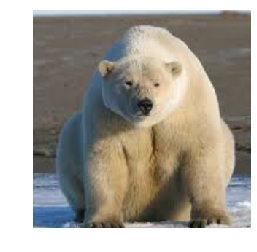

Labrador retriever: 59.12%
Chesapeake Bay retriever: 18.94%
golden retriever: 3.78%
Rhodesian ridgeback: 1.29%
bull mastiff: 0.73%


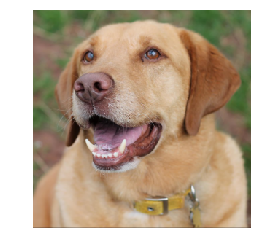

prairie chicken, prairie grouse, prairie fowl: 62.69%
ruffed grouse, partridge, Bonasa umbellus: 7.11%
great grey owl, great gray owl, Strix nebulosa: 5.58%
quail: 3.90%
partridge: 2.82%


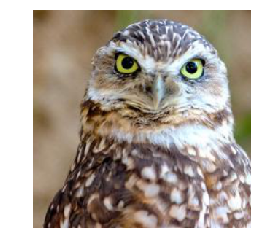

lion, king of beasts, Panthera leo: 95.65%
tiger, Panthera tigris: 0.09%
cheetah, chetah, Acinonyx jubatus: 0.08%
chow, chow chow: 0.08%
stopwatch, stop watch: 0.06%


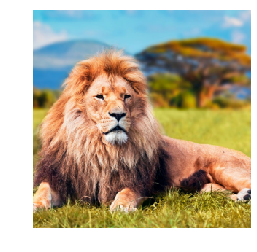

grey fox, gray fox, Urocyon cinereoargenteus: 58.36%
kit fox, Vulpes macrotis: 11.62%
red fox, Vulpes vulpes: 2.21%
mongoose: 0.92%
Arctic fox, white fox, Alopex lagopus: 0.86%


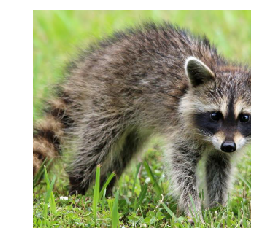

armadillo: 92.70%
water tower: 0.09%
spindle: 0.05%
airship, dirigible: 0.05%
warthog: 0.04%


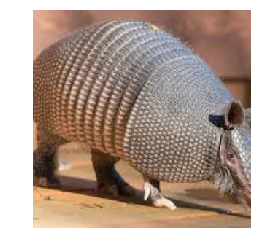

hippopotamus, hippo, river horse, Hippopotamus amphibius: 93.70%
lion, king of beasts, Panthera leo: 0.07%
tusker: 0.06%
warthog: 0.05%
stopwatch, stop watch: 0.04%


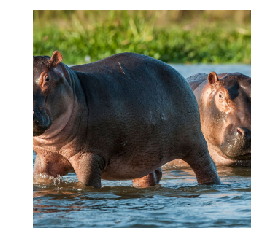

tiger, Panthera tigris: 90.64%
tiger cat: 5.69%
jaguar, panther, Panthera onca, Felis onca: 0.11%
leopard, Panthera pardus: 0.03%
tabby, tabby cat: 0.03%


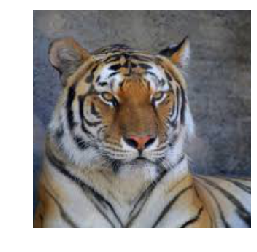

In [57]:
# Get the most likely labels and compare the output of the model
# to the actual picture.

for img, pred in zip(X_test, predictions_val):
  top_5 = np.argpartition(pred, -5)[-5:]
  top_5 = reversed(top_5[np.argsort(pred[top_5])])
  for i in top_5:
    print("{0}: {1:.2f}%".format(labels[i], 100 * pred[i]))
  plt.imshow((img + 1) / 2)
  plt.axis('off')
  plt.show()